Upload image to apply artistic filter:


Saving people image.jpg to people image.jpg

Available presets: soft_cartoon, strong_cartoon, sketchy
Type preset name to use, 'list' to see presets, 'save' to save current custom as preset, or type 'custom' to enter params: strong-cartoon
Unknown choice — falling back to 'soft_cartoon'.
Saved: artistic_cartoon.jpg


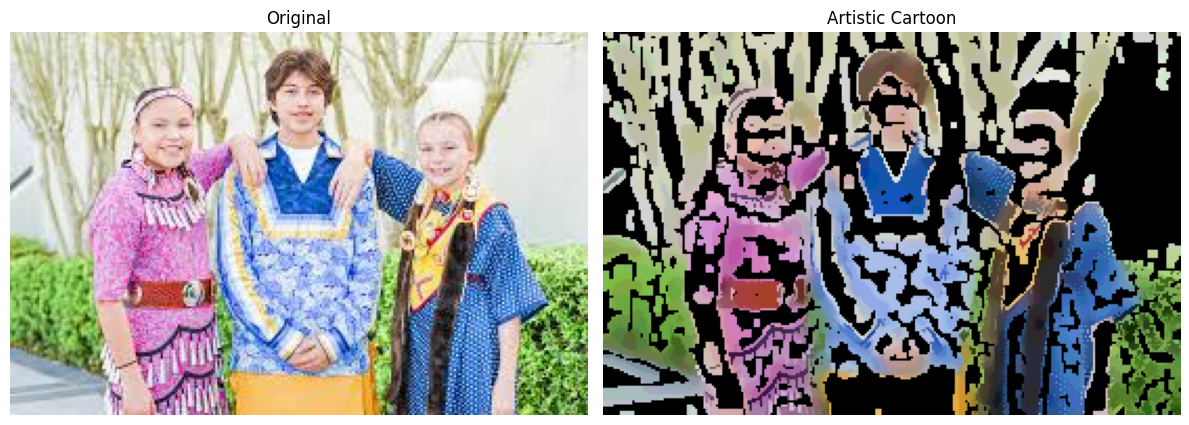

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# =========================================================
# 🎭 Project 2 — Artistic Filter App (Colab-ready)
# - Upload an image
# - Apply repeated bilateral filtering (smooth colors)
# - Extract strong edges (adaptive threshold or Canny)
# - Combine edges + smooth color to produce a "cartoon" look
# - Choose presets, save presets, save final image
# =========================================================

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# -------------------------
# Helper: cartoonize function
# -------------------------
def cartoonize(
    img_bgr,
    bilateral_iters=5,     # how many times to apply bilateral filter
    bilateral_d=9,         # diameter of each pixel neighborhood
    bilateral_sigmaColor=75,
    bilateral_sigmaSpace=75,
    median_ksize=7,        # median blur kernel for edge detection (odd)
    use_canny=False,       # if True use Canny for edges, else adaptive threshold
    canny_thr1=100,
    canny_thr2=200,
    edge_dilate=1,         # dilate edges to make them bolder
    posterize_levels=None  # if int -> reduce color levels (e.g., 8)
):
    # 1) smooth colors by repeating bilateral filtering
    smooth = img_bgr.copy()
    for _ in range(max(1, bilateral_iters)):
        smooth = cv2.bilateralFilter(smooth, bilateral_d, bilateral_sigmaColor, bilateral_sigmaSpace)

    # Optional: posterize (reduce number of color values) to get flat regions
    if posterize_levels and posterize_levels > 1:
        # convert to float, quantize
        factor = 256 // posterize_levels
        smooth = (smooth // factor) * factor
        smooth = smooth.astype(np.uint8)

    # 2) prepare edges
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, median_ksize)

    if use_canny:
        edges = cv2.Canny(gray_blur, canny_thr1, canny_thr2)
        # Canny gives thin edges; dilate to thicken
        if edge_dilate > 0:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (edge_dilate*2+1, edge_dilate*2+1))
            edges = cv2.dilate(edges, kernel, iterations=1)
    else:
        # Adaptive threshold for stylized thick edges
        edges = cv2.adaptiveThreshold(
            gray_blur, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            9,  # blockSize (fixed here to 9 for good effect), can be parameterized
            2
        )
        # edges now white lines on black background; we want black lines, so invert
        edges = cv2.bitwise_not(edges)
        if edge_dilate > 0:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (edge_dilate*2+1, edge_dilate*2+1))
            edges = cv2.dilate(edges, kernel, iterations=1)

    # 3) combine smooth color & edges
    # edges: 255 means background (we inverted for adaptive), so invert again to get mask if needed
    if edges.ndim == 2:
        mask = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # 3 channel mask
    else:
        mask = edges

    # Create final by bitwise_and so color shows where mask is white
    cartoon_bgr = cv2.bitwise_and(smooth, mask)

    return cartoon_bgr

# -------------------------
# Default presets
# -------------------------
default_presets = {
    "soft_cartoon": {
        "bilateral_iters": 4, "bilateral_d": 9, "bilateral_sigmaColor": 75, "bilateral_sigmaSpace": 75,
        "median_ksize": 7, "use_canny": False, "edge_dilate": 1, "posterize_levels": 12
    },
    "strong_cartoon": {
        "bilateral_iters": 7, "bilateral_d": 9, "bilateral_sigmaColor": 100, "bilateral_sigmaSpace": 100,
        "median_ksize": 7, "use_canny": False, "edge_dilate": 2, "posterize_levels": 8
    },
    "sketchy": {
        "bilateral_iters": 1, "bilateral_d": 9, "bilateral_sigmaColor": 50, "bilateral_sigmaSpace": 50,
        "median_ksize": 5, "use_canny": True, "canny_thr1": 50, "canny_thr2": 150, "edge_dilate": 1, "posterize_levels": None
    }
}

# Save presets file helper
PRESET_FILENAME = "cartoon_presets.json"
if os.path.exists(PRESET_FILENAME):
    try:
        with open(PRESET_FILENAME, "r") as f:
            saved_presets = json.load(f)
            default_presets.update(saved_presets)
    except Exception:
        pass  # ignore corrupt file

# -------------------------
# 0) Upload image
# -------------------------
print("Upload image to apply artistic filter:")
up = files.upload()
img_path = list(up.keys())[0]

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("Could not read the image. Re-upload a valid JPG/PNG.")

# -------------------------
# 1) Ask user to choose preset or custom
# -------------------------
print("\nAvailable presets:", ", ".join(default_presets.keys()))
choice = input("Type preset name to use, 'list' to see presets, 'save' to save current custom as preset, or type 'custom' to enter params: ").strip()

params = None

if choice == "list":
    print(json.dumps(default_presets, indent=2))
    choice = input("Now type preset name to use or 'custom': ").strip()

if choice in default_presets:
    params = default_presets[choice]
    print(f"Using preset: {choice}")
elif choice == "custom":
    # Basic prompt-style custom parameter input
    try:
        bilateral_iters = int(input("bilateral_iters (e.g., 4): ") or "4")
        bilateral_d = int(input("bilateral_d (odd, e.g., 9): ") or "9")
        bilateral_sigmaColor = float(input("bilateral_sigmaColor (e.g., 75): ") or "75")
        bilateral_sigmaSpace = float(input("bilateral_sigmaSpace (e.g., 75): ") or "75")
        median_ksize = int(input("median_ksize (odd, e.g., 7): ") or "7")
        use_canny = input("use_canny? (y/N): ").strip().lower() == "y"
        canny_thr1 = int(input("canny_thr1 (if Canny, e.g., 100): ") or "100")
        canny_thr2 = int(input("canny_thr2 (if Canny, e.g., 200): ") or "200")
        edge_dilate = int(input("edge_dilate (e.g., 1): ") or "1")
        posterize_levels_in = input("posterize_levels (int or blank for none, e.g., 8): ").strip()
        posterize_levels = int(posterize_levels_in) if posterize_levels_in else None

        params = {
            "bilateral_iters": bilateral_iters,
            "bilateral_d": bilateral_d,
            "bilateral_sigmaColor": bilateral_sigmaColor,
            "bilateral_sigmaSpace": bilateral_sigmaSpace,
            "median_ksize": median_ksize,
            "use_canny": use_canny,
            "canny_thr1": canny_thr1,
            "canny_thr2": canny_thr2,
            "edge_dilate": edge_dilate,
            "posterize_levels": posterize_levels
        }

        # Option to save this custom as preset
        save_choice = input("Save these params as a new preset? (y/N): ").strip().lower()
        if save_choice == "y":
            name = input("Preset name: ").strip()
            if name:
                default_presets[name] = params
                with open(PRESET_FILENAME, "w") as f:
                    json.dump({k:v for k,v in default_presets.items()}, f, indent=2)
                print(f"Saved preset '{name}' to {PRESET_FILENAME}")

    except Exception as e:
        print("Error reading custom params, falling back to 'soft_cartoon'.", e)
        params = default_presets["soft_cartoon"]
else:
    print("Unknown choice — falling back to 'soft_cartoon'.")
    params = default_presets["soft_cartoon"]

# -------------------------
# 2) Run filter
# -------------------------
cartoon = cartoonize(img_bgr, **params)

# -------------------------
# 3) Save & preview
# -------------------------
out_name = "artistic_cartoon.jpg"
cv2.imwrite(out_name, cartoon)
print(f"Saved: {out_name}")

# Display side-by-side (convert BGR->RGB for matplotlib)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
cartoon_rgb = cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(cartoon_rgb); plt.title("Artistic Cartoon"); plt.axis("off")
plt.tight_layout(); plt.show()

# Offer download
files.download(out_name)
